In [2]:
#程序的第一部分——在网页上爬取数据

from selenium import webdriver
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By
from selenium.common import NoSuchElementException
# 载入sleep函数控制速度以免被网站封禁
from time import sleep

import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import re

def Price_Data_Spider(url,location):
    driver.get(url)
    data = []
    # 设置计数器控制数据规模
    loop_count=0
    while True:
        # 观察到所有的有用数据都储存在标签为dl的HTML环境中
        dl_list = driver.find_elements(By.TAG_NAME,'dl')
        for dl in dl_list:
            row = []
            # 观察到所有的面积数据都储存在类为tel_shop的环境中
            area = dl.find_elements(By.CLASS_NAME,'tel_shop')
            if area:
                temp = re.findall(r'\d+.\d+㎡|\d+㎡', area[0].text)
                row = re.findall(r'\d+.\d+|\d+', temp[0])
            # 观察到所有的价格数据都储存在类为price_right中
            price = dl.find_elements(By.CLASS_NAME,'price_right')
            if price:
                # 注意到price_rignt类中有时会出现我们不想要的price_dy，因此只取前两项总价与均价
                row += re.findall(r'\d+\.\d+|\d+', price[0].text)[0:2]
            # dl标签中没有数据的环境被舍弃
            if(row!=[]):
                row.append(location)   
                data.append(row)
        loop_count+=1
        if loop_count>=101:
            break
        try:
            # 进入下一页
            NextPage = driver.find_element(By.LINK_TEXT,'下一页')
            driver.execute_script("arguments[0].click();", NextPage)
        except NoSuchElementException: 
            break
    # 生成DataFrame类储存数据，并为各列命名
    df = pd.DataFrame(data,columns=['area(m2)','price(10kRMB)','price_avrg(RMB/m2)','location'])
    return(df)


def Rent_Data_Spider(url,location):
    driver.get(url)
    data = []
    loop_count=0
    while True:
        # 观察到所有有用数据都储存在list hiddenMap rel类中，由于类名中有空格，因此采用CSS_SELECTOR检索
        rel_list = driver.find_elements(By.CSS_SELECTOR, '.list.hiddenMap.rel')
        for rel in rel_list:
            row = []
            # 观察到所有面积数据都储存在font15 mt12 bold中，仍由于类名中有空格，因此采用CSS_SELECTOR检索
            area = rel.find_elements(By.CSS_SELECTOR,'.font15.mt12.bold')
            if area:
                temp = re.findall(r'\d+.\d+㎡|\d+㎡', area[0].text)
                row = re.findall(r'\d+.\d+|\d+', temp[0])
            # 观察到所有价格数据都储存在名为price的HTML类中
            rent = rel.find_elements(By.CSS_SELECTOR,'.price')
            if rent:
                row += re.findall(r'\d+\.\d+|\d+', rent[0].text)
            # info.ref类中没有数据的环境被舍弃
            if(row!=[]):
                row.append(location)
                data.append(row)
        loop_count+=1
        if loop_count>=101:
            break
        try:
            NextPage = driver.find_element(By.LINK_TEXT,'下一页')
            driver.execute_script("arguments[0].click();", NextPage)
        except NoSuchElementException: 
            break
    df = pd.DataFrame(data,columns=['area(m2)','rent(RMB/month)','location'])
    return(df)




In [ ]:
# 先预先储存要爬取的网页地址列表
price_url_list=['https://tj.esf.fang.com/house-a037/',
          'https://tj.esf.fang.com/house-a041/',
          'https://tj.esf.fang.com/house-a010383/',
          'https://tj.esf.fang.com/house-a052/'
          ]
rent_url_list=['https://tj.zu.fang.com/house-a037/',
               'https://tj.zu.fang.com/house-a041/',
               'https://tj.zu.fang.com/house-a010383/',
               'https://tj.zu.fang.com/house-a052/'
            ]
# 同时标注每个地址所对应的地区名称
name_list=['和平','南开','滨海','武清']
# 初始化列表储存每个地区的价格或租金数据
price_data_list=[]
rent_data_list=[]
driver = webdriver.Edge()

for i in range(len(name_list)):
    price_data_list.append(Price_Data_Spider(price_url_list[i],name_list[i]))
    rent_data_list.append(Rent_Data_Spider(rent_url_list[i],name_list[i]))

In [4]:

# 合并价格与租金数据，并储存到本地
price_data_all=pd.concat(price_data_list,axis=0,ignore_index=True)
print(price_data_all)
price_data_all.to_csv('price_data_all_output.csv', index=False, encoding='utf-8-sig')
price_data_list[0].to_csv('price_data_heping_output.csv',index=False, encoding='utf-8-sig')

rent_data_all=pd.concat(rent_data_list,axis=0,ignore_index=True)
print(rent_data_all)
rent_data_all.to_csv('rent_data_all_output.csv', index=False, encoding='utf-8-sig')
rent_data_list[0].to_csv('rent_data_heping_output.csv',index=False, encoding='utf-8-sig')

# 关闭浏览器，清除环境中所有的变量
driver.quit()
%reset

#  程序的第一部分结束

      area(m2) price(10kRMB) price_avrg(RMB/m2) location
0           55           275              50000       和平
1           14           105              75000       和平
2        21.85            95              43478       和平
3           24           108              45000       和平
4           53           265              50000       和平
...        ...           ...                ...      ...
23566      246           175               7113       武清
23567      186           225              12096       武清
23568      246           248              10081       武清
23569      208           195               9375       武清
23570      203           135               6650       武清

[23571 rows x 4 columns]
     area(m2) rent(RMB/month) location
0          60            3300       和平
1          30            1800       和平
2          86            5900       和平
3         137           12000       和平
4         174           12000       和平
...       ...             ...      ...
2549       62    

In [17]:
# 程序的第二部分——整理数据并得到价格——租金比的中位数（在此数据结构下房产不可能同时待售与待租，因此我们将其定义为价格中位数与租金中位数之比）

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm

name_list=['南开','和平','武清','滨海']

# detect_outliers的功能是输入数据集df与确定离群值的凭据变量名列表var_list，最终得到一个bool列表确定每一行是否包含离群值
def detect_outliers(df,var_list=None):
    if var_list==None:
        var_list=df.columns.tolist()
    is_outlier=[False]*len(df)
    for var in var_list:
        # 只对数值型变量考虑离群值
        if pd.api.types.is_numeric_dtype(df[var]):
            # 使用Tukey's Fences法定义离群值
            Q1=df[var].quantile(0.25)
            Q3=df[var].quantile(0.75)
            IQR=Q3-Q1
            lower_bound=Q1-1.5*IQR
            upper_bound=Q3+1.5*IQR
            for i in range(len(df[var])):
                if (df[var].iloc[i]>upper_bound or df[var].iloc[i]<lower_bound):is_outlier[i]=True
    return (pd.Series(is_outlier,index=df.index))


# 导入的文件可更改以适应不同样本要求
price_data=pd.read_csv('price_data_all_output.csv',encoding='utf-8-sig')
rent_data=pd.read_csv('rent_data_all_output.csv',encoding='utf-8-sig')
rent_data['rent_avrg(RMB/(m2*month))']=rent_data['rent(RMB/month)']/rent_data['area(m2)']
print(price_data)
print(rent_data)

# 重新得到每个区域的数据
price_data_list=[]
rent_data_list=[]
for i in range(len(name_list)):
    price_data_list.append(price_data[price_data['location']==name_list[i]])
    rent_data_list.append(rent_data[rent_data['location']==name_list[i]])

       area(m2)  price(10kRMB)  price_avrg(RMB/m2) location
0         55.00          275.0               50000       和平
1         14.00          105.0               75000       和平
2         21.85           95.0               43478       和平
3         24.00          108.0               45000       和平
4         53.00          265.0               50000       和平
...         ...            ...                 ...      ...
23566    246.00          175.0                7113       武清
23567    186.00          225.0               12096       武清
23568    246.00          248.0               10081       武清
23569    208.00          195.0                9375       武清
23570    203.00          135.0                6650       武清

[23571 rows x 4 columns]
      area(m2)  rent(RMB/month) location  rent_avrg(RMB/(m2*month))
0           60             3300       和平                  55.000000
1           30             1800       和平                  60.000000
2           86             5900       和平          

price data description of 南开  :
          area(m2)  price(10kRMB)  price_avrg(RMB/m2)
count  6000.000000    6000.000000         6000.000000
mean     96.419932     302.938485        30393.828833
std      38.687737     178.570426         8710.425145
min      13.960000      32.000000        11974.000000
25%      68.480000     170.000000        23795.000000
50%      95.190000     279.000000        29819.000000
75%     117.190000     380.000000        35731.500000
max     304.450000    1800.000000        94206.000000
rent data description of 南开  :
          area(m2)  rent(RMB/month)  rent_avrg(RMB/(m2*month))
count  1078.000000      1078.000000                1078.000000
mean     78.795918      3719.500928                  47.664677
std      39.196066      2561.286169                  16.070580
min      12.000000       880.000000                   9.712230
25%      53.000000      2300.000000                  37.931034
50%      73.000000      3100.000000                  45.744681
75%      9

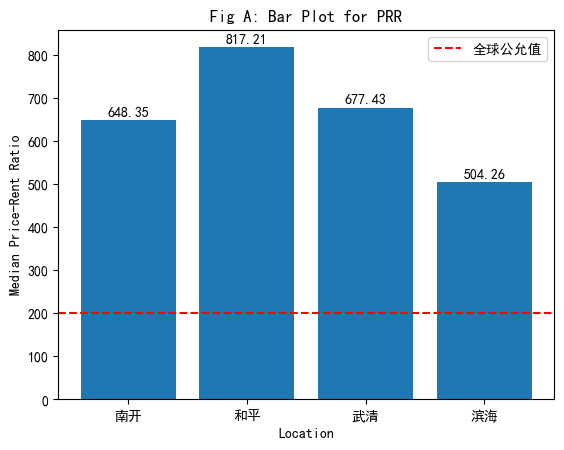

In [19]:
# 分地区数据描述
for i in range(len(name_list)):
    print('price data description of',name_list[i],' :')
    print(price_data_list[i].describe())
    print('rent data description of',name_list[i],' :')
    print(rent_data_list[i].describe())
    
# 全样本数据描述
print("Price Data Description:")
print(price_data.describe())
print("\nRent Data Description:")
print(rent_data.describe())

'''
# 展示离群值（可选）
# 可以改变需要检测离群值的变量列表var_list，此处以全样本为例，选择均价与均租金展示离群值
print(price_data[detect_outliers(price_data,['price_avrg(RMB/m2)'])])
print(rent_data[detect_outliers(rent_data,['rent_avrg(RMB/(m2*month))'])])
'''

# 初始化价格——租金比的储存变量
median_PRR=[]
for i in range(len(name_list)):
    # 去除极端值后再求中位数
    price_data_list[i]=price_data_list[i][~detect_outliers(price_data_list[i],['price_avrg(RMB/m2)'])]
    rent_data_list[i]=rent_data_list[i][~detect_outliers(rent_data_list[i],['rent_avrg(RMB/(m2*month))'])]
    # 面均价格与面均租金的比值就是价格——租金比
    median_PRR.append(price_data_list[i]['price_avrg(RMB/m2)'].median()/rent_data_list[i]['rent_avrg(RMB/(m2*month))'].median())
    print('median price to rent ratio of ',name_list[i],' is ',median_PRR[i])

# 柱状图
plt.rcParams['font.sans-serif'] = ['SimHei'] 
plt.rcParams['axes.unicode_minus'] = False 
bars=plt.bar(name_list, median_PRR)
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 5,
              f'{height:.2f}',ha='center', va='bottom')
plt.axhline(y=200, color='r', linestyle='--', label='全球公允值')
plt.title('Fig A: Bar Plot for PRR')
plt.xlabel('Location')
plt.ylabel('Median Price-Rent Ratio')
plt.legend()
plt.show()

#程序的第二部分结束

In [23]:
# 程序的第三部分——构建OLS统计模型并预测PRR

# 模型构建

import pandas as pd
import statsmodels.api as sm

# 将字符型变量转化为数个二元变量
df = pd.get_dummies(price_data, columns=['location'], drop_first=True)
# 将所有变量都转化为float类型
df[df.columns]=df[df.columns].astype(float)
# 生成交互项
df['area_location_和平'] = df['area(m2)'] * df['location_和平']
df['area_location_武清'] = df['area(m2)'] * df['location_武清']
df['area_location_滨海'] = df['area(m2)'] * df['location_滨海']

# 生成特征矩阵
X = sm.add_constant(df[['area(m2)', 'location_和平', 'location_武清', 'location_滨海', 'area_location_和平', 'area_location_武清', 'area_location_滨海']])
# 生成目标向量
y = df['price_avrg(RMB/m2)']
# 构建OLS模型
price_lm = sm.OLS(y, X).fit()
print(price_lm.summary())


# 租金模型的构建是完全同理的
df = pd.get_dummies(rent_data, columns=['location'], drop_first=True)
df[df.columns]=df[df.columns].astype(float)
df['area_location_和平'] = df['area(m2)'] * df['location_和平']
df['area_location_武清'] = df['area(m2)'] * df['location_武清']
df['area_location_滨海'] = df['area(m2)'] * df['location_滨海']
X = sm.add_constant(df[['area(m2)', 'location_和平', 'location_武清', 'location_滨海', 'area_location_和平', 'area_location_武清', 'area_location_滨海']])
y = df['rent_avrg(RMB/(m2*month))']
rent_lm = sm.OLS(y, X).fit()
print(rent_lm.summary())

                            OLS Regression Results                            
Dep. Variable:     price_avrg(RMB/m2)   R-squared:                       0.766
Model:                            OLS   Adj. R-squared:                  0.766
Method:                 Least Squares   F-statistic:                 1.103e+04
Date:                Thu, 20 Mar 2025   Prob (F-statistic):               0.00
Time:                        18:55:00   Log-Likelihood:            -2.5183e+05
No. Observations:               23571   AIC:                         5.037e+05
Df Residuals:                   23563   BIC:                         5.037e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const             2.403e+04    366.240  


 prices predicted are
    area location         price
0    50       南开  27330.181672
1    50       和平  59687.426136
2    50       武清   9836.924768
3    50       滨海  12043.591791
4   100       南开  30630.108074
5   100       和平  51764.833891
6   100       武清  11376.406924
7   100       滨海  13777.892673

 rents predicted are
    area location       rent
0    50       南开  48.345335
1    50       和平  66.663876
2    50       武清  16.432695
3    50       滨海  27.391811
4   100       南开  47.163469
5   100       和平  67.838039
6   100       武清  17.993309
7   100       滨海  27.713234


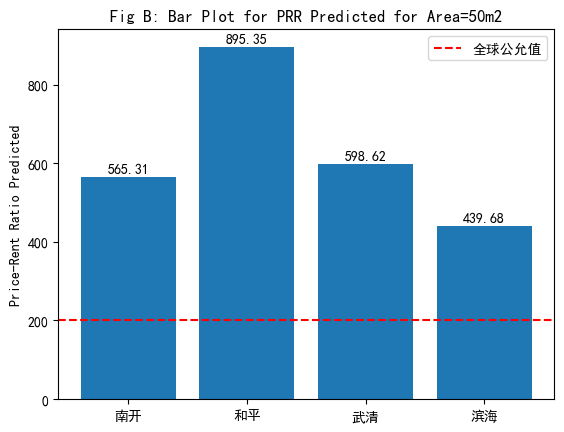

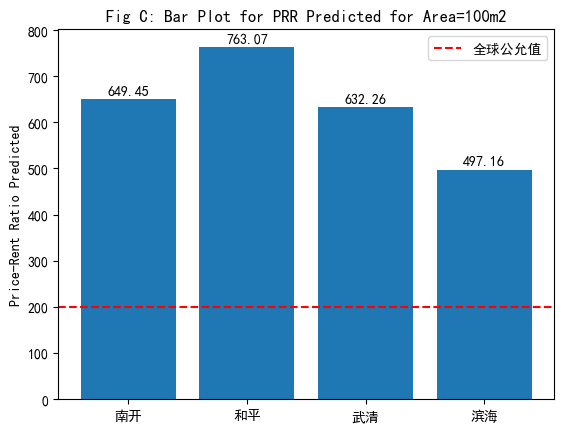

In [25]:
# 生成新数据的基本元素
new_x_area=np.array([50,50,50,50,100,100,100,100])
new_x_location=np.array(name_list*2)

# 用基本元素（面积与地区）重现特征矩阵new_x
new_x = {
    'area(m2)': new_x_area,
    'location_和平': (new_x_location==np.array([name_list[1]]*2*len(name_list))).astype(int),
    'location_武清': (new_x_location==np.array([name_list[2]]*2*len(name_list))).astype(int),
    'location_滨海': (new_x_location==np.array([name_list[3]]*2*len(name_list))).astype(int)
}
new_x=pd.DataFrame(new_x)
new_x['area_location_和平']=new_x['area(m2)']*new_x['location_和平']
new_x['area_location_武清']=new_x['area(m2)']*new_x['location_武清']
new_x['area_location_滨海']=new_x['area(m2)']*new_x['location_滨海']

# 得到将基本信息与预测值整合在一起
price_prdct =  pd.DataFrame({
    'area': new_x_area,
    'location': new_x_location,
    'price':price_lm.predict(sm.add_constant(new_x))
})
rent_prdct = pd.DataFrame({
    'area': new_x_area,
    'location': new_x_location,
    'rent':rent_lm.predict(sm.add_constant(new_x))
})

# 展示之
print('\n prices predicted are\n',price_prdct)
print('\n rents predicted are\n',rent_prdct)

# 计算预测价格与预测租金的比例，PRR_prdct
PRR_prdct= pd.DataFrame({
    'area': new_x_area,
    'location': new_x_location,
    'PRR':price_prdct['price']/rent_prdct['rent']
})

# 将数据分半，以得到图B与图C
fig_B_data=PRR_prdct.iloc[0:4]
fig_C_data=PRR_prdct.iloc[4:8]

#制图
plt.rcParams['font.sans-serif'] = ['SimHei'] 
plt.rcParams['axes.unicode_minus'] = False 
bars=plt.bar(fig_B_data['location'], fig_B_data['PRR'])
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 5,
              f'{height:.2f}',ha='center', va='bottom')
plt.axhline(y=200, color='r', linestyle='--', label='全球公允值')
plt.title('Fig B: Bar Plot for PRR Predicted for Area=50m2')
plt.xlabel('')
plt.ylabel('Price-Rent Ratio Predicted')
plt.legend()
plt.show()

bars=plt.bar(fig_C_data['location'], fig_C_data['PRR'])
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 5,
              f'{height:.2f}',ha='center', va='bottom')
plt.axhline(y=200, color='r', linestyle='--', label='全球公允值')
plt.title('Fig C: Bar Plot for PRR Predicted for Area=100m2')
plt.xlabel('')
plt.ylabel('Price-Rent Ratio Predicted')
plt.legend()
plt.show()
